In [1]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

## Here I wrote code for ADF 

In [2]:
def anisotropicFilter(img1, numIter, conEff, lam,option):
    img = np.copy(img1)
    H, W = img.shape
    for i in range(numIter):
        denoisedImg = np.zeros([H+2, W+2]).astype('uint8')
        denoisedImg[1:H+1, 1:W+1] = img
        deltaUp = denoisedImg[0:H, 1:W+1] - img
        deltaDown = denoisedImg[2:H+2, 1:W+1] - img
        deltaRight = denoisedImg[1:H+1, 2:W+2] - img
        deltaLeft = denoisedImg[1:H+1, 0:H] - img
        kappa = conEff
        if option == 1:
            cN = np.exp(-(deltaUp / kappa) ** 2)
            cS = np.exp(-(deltaDown / kappa) ** 2)
            cE = np.exp(-(deltaRight / kappa) ** 2)
            cW = np.exp(-(deltaLeft / kappa) ** 2)
        elif option == 2:
            cN = 1 / (1 + (deltaUp / kappa) ** 2)
            cS = 1 / (1 + (deltaDown / kappa) ** 2)
            cE = 1 / (1 + (deltaRight / kappa) ** 2)
            cW = 1 / (1 + (deltaLeft / kappa) ** 2)
        img = img + lam * (cN * deltaUp + cS * deltaDown + cE * deltaRight + cW * deltaLeft)

    return img



## Importing and adding noise to image

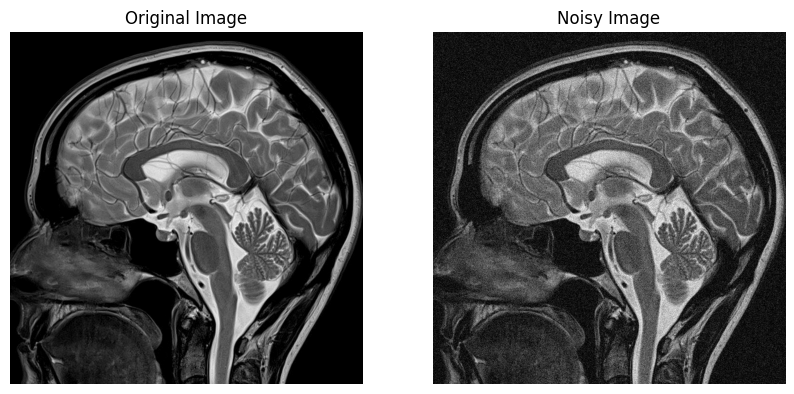

In [3]:
img=cv.imread('image_anisotropic.png',0)
imgNormalized = img.astype(np.float32) / 255
mean = 0.05
variance = 0.01
noise = np.random.normal(mean, np.sqrt(variance), img.shape)

noisyImg = imgNormalized + noise
noisyImg = np.clip(noisyImg, 0, 1)
noisyImg = (noisyImg * 255).astype(np.uint8)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(noisyImg, cmap='gray')
plt.title('Noisy Image')
plt.axis('off')

plt.show()

## In this part I finding the best hyperparameters based on PNSR and SSIM 
## Option 1

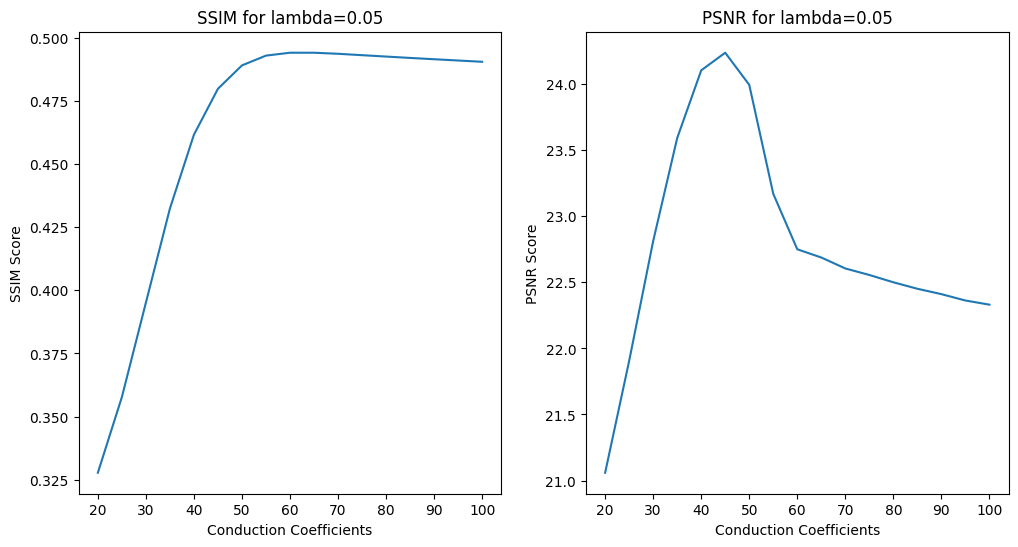

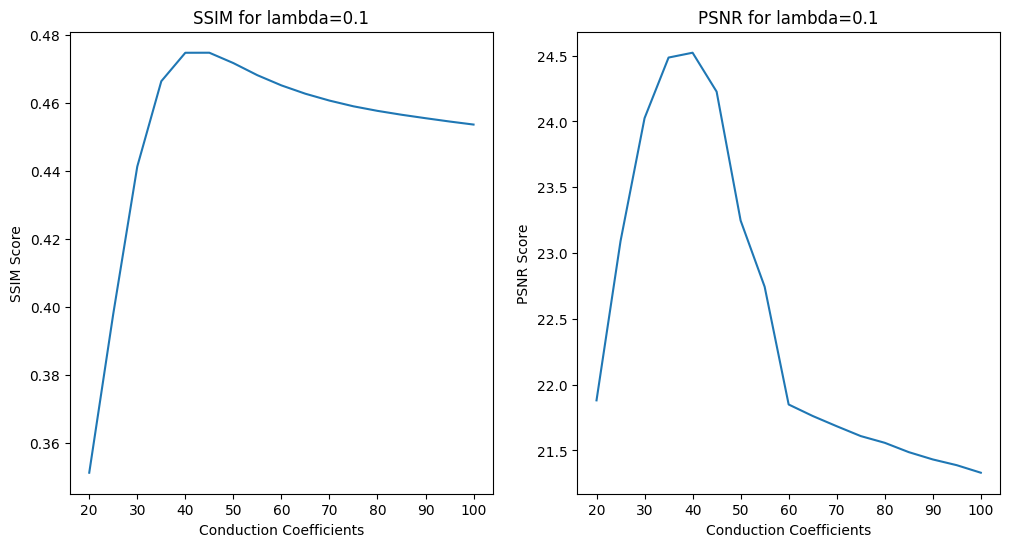

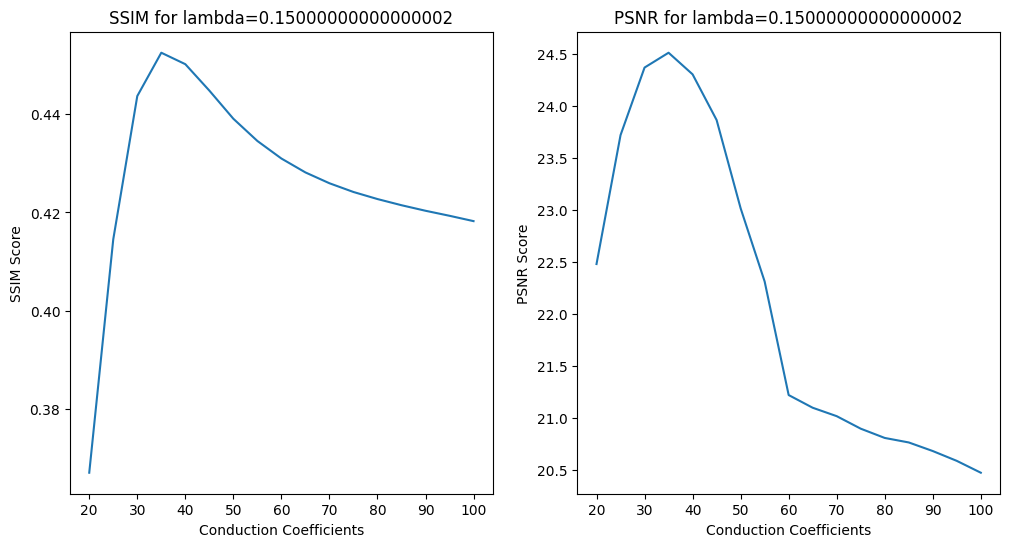

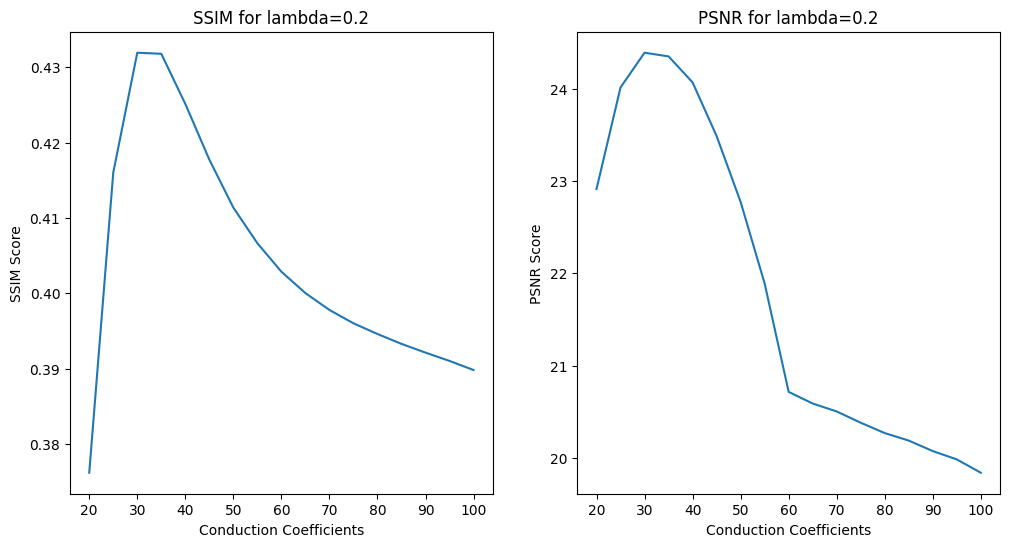

In [4]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
ssims = []
PSNR = []
coeffValues = []
lambdas = np.arange(0.05, 0.2, 0.05)
nIter = 20
option = 1

for lambd in lambdas:
    ssims_lambda = []
    PSNR_lambda = []
    coeffValues = []

    for coeff in range(20, 105, 5):
        coeffValues.append(coeff)
        anisoImDenoised = anisotropicFilter(noisyImg, nIter, coeff, lambd, option)
        ssimScore = ssim(anisoImDenoised, img, data_range=img.max() - img.min())
        PSNRScore = psnr(anisoImDenoised / np.max(anisoImDenoised), img / np.max(img))
        ssims_lambda.append(ssimScore)
        PSNR_lambda.append(PSNRScore)

    ssims.append(ssims_lambda)
    PSNR.append(PSNR_lambda)

for i, lambd in enumerate(lambdas):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(coeffValues, ssims[i])
    plt.title(f'SSIM for lambda={lambd}')
    plt.xlabel('Conduction Coefficients')
    plt.ylabel('SSIM Score')

    plt.subplot(1, 2, 2)
    plt.plot(coeffValues, PSNR[i])
    plt.title(f'PSNR for lambda={lambd}')
    plt.xlabel('Conduction Coefficients')
    plt.ylabel('PSNR Score')

    plt.show()


In [5]:
max_ssim_index = np.unravel_index(np.argmax(ssims), np.array(ssims).shape)
max_ssim_lambda = lambdas[max_ssim_index[0]]
max_ssim_coeff = coeffValues[max_ssim_index[1]]
max_ssim_value = ssims[max_ssim_index[0]][max_ssim_index[1]]

print(f"Maximum SSIM value: {max_ssim_value:.2f}")
print(f"Related lambda: {max_ssim_lambda:.2f}")
print(f"Related coefficient: {max_ssim_coeff}")
max_psnr_index = np.unravel_index(np.argmax(PSNR), np.array(PSNR).shape)
max_psnr_lambda = lambdas[max_psnr_index[0]]
max_psnr_coeff = coeffValues[max_psnr_index[1]]
max_psnr_value = PSNR[max_psnr_index[0]][max_psnr_index[1]]

print(f"Maximum PSNR value: {max_psnr_value:.2f}")
print(f"Related lambda: {max_psnr_lambda:.2f}")
print(f"Related coefficient: {max_psnr_coeff}")


Maximum SSIM value: 0.49
Related lambda: 0.05
Related coefficient: 60
Maximum PSNR value: 24.52
Related lambda: 0.10
Related coefficient: 40


## the best denoised images based on the best hyperparameters


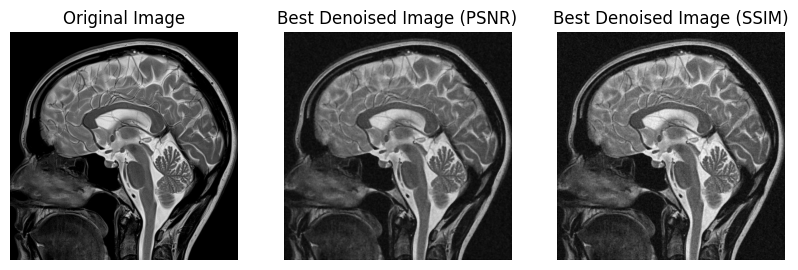

In [6]:
bestDenoisedPNSR1=anisotropicFilter(noisyImg, 20, 40, 0.1, 1)
bestDenoisedSSIM1=anisotropicFilter(noisyImg, 20, 60, 0.05, 1)
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(bestDenoisedPNSR1, cmap='gray')
plt.title('Best Denoised Image (PSNR)')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(bestDenoisedSSIM1, cmap='gray')
plt.title('Best Denoised Image (SSIM)')
plt.axis('off')

plt.show()

## In this part I finding the best hyperparameters based on PNSR and SSIM 
## Option 2

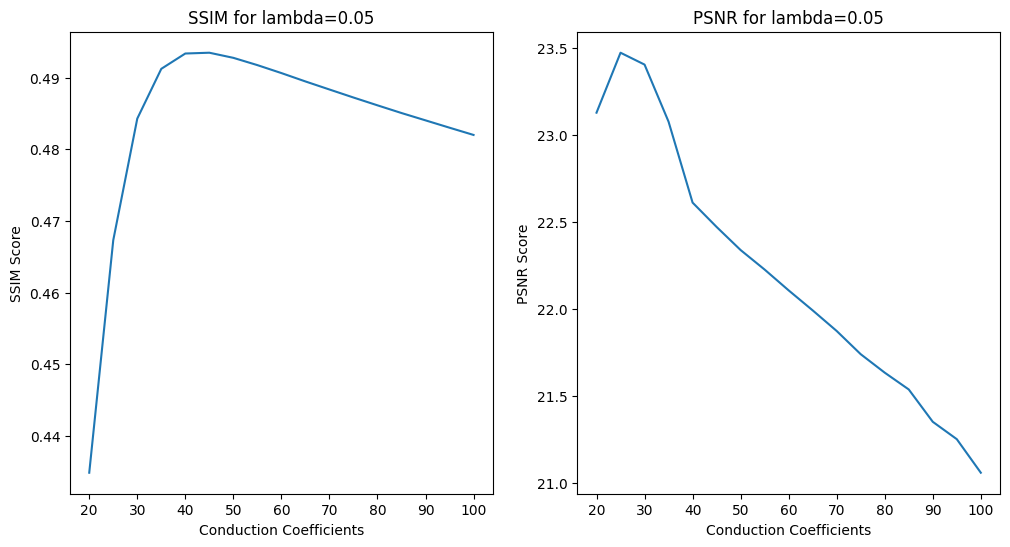

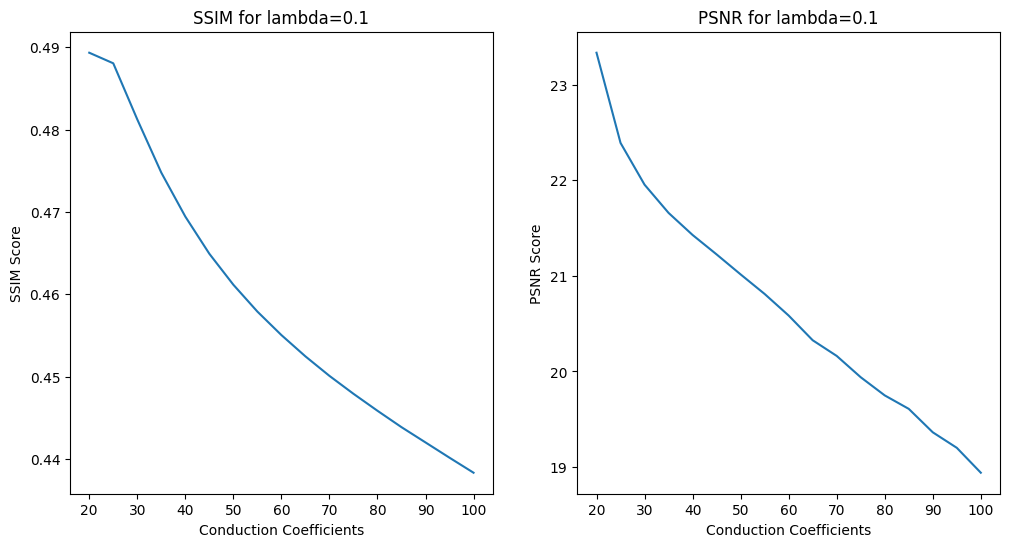

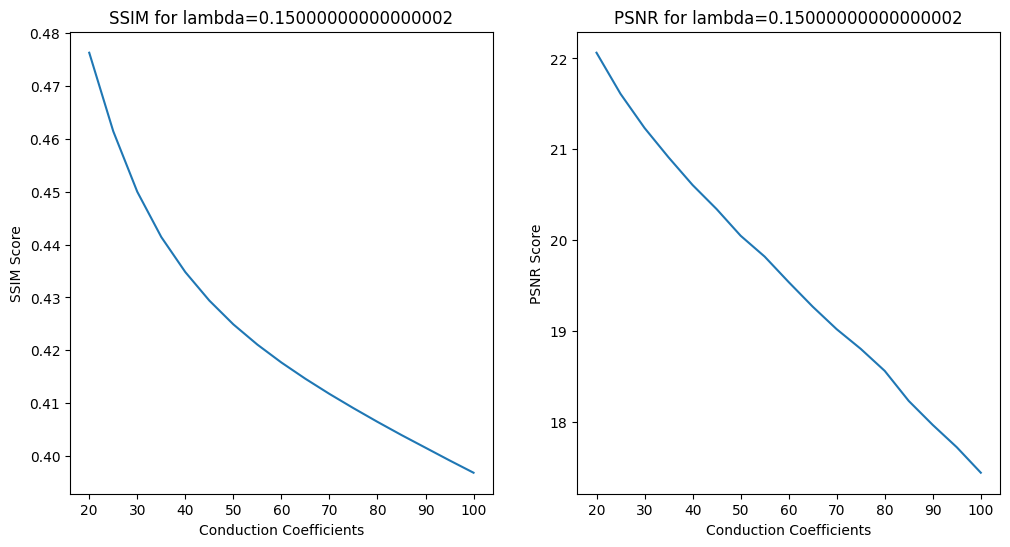

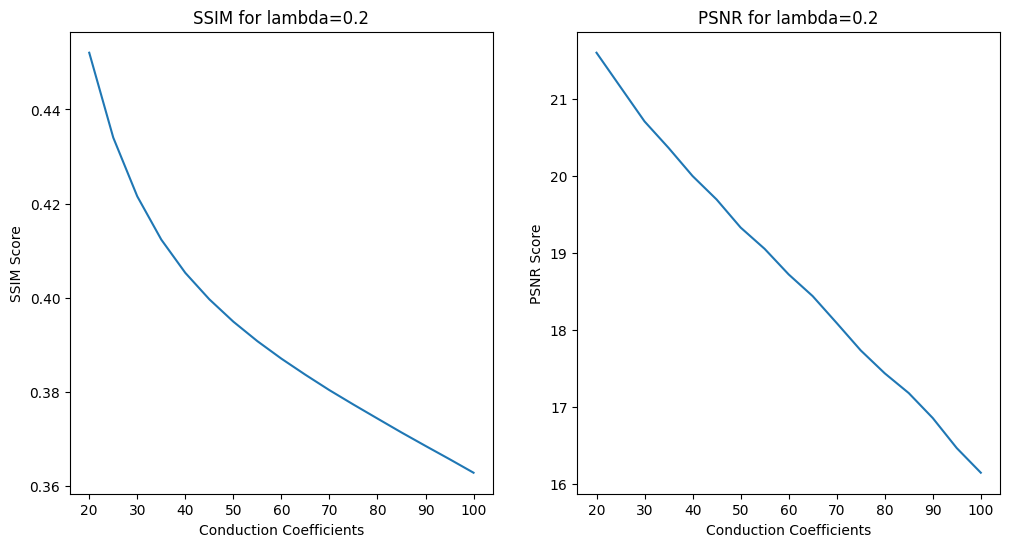

In [7]:

ssims = []
PSNR = []
coeffValues = []
lambdas = np.arange(0.05, 0.2, 0.05)
nIter = 20
option = 2

for lambd in lambdas:
    ssims_lambda = []
    PSNR_lambda = []
    coeffValues = []

    for coeff in range(20, 105, 5):
        coeffValues.append(coeff)
        anisoImDenoised = anisotropicFilter(noisyImg, nIter, coeff, lambd, option)
        ssimScore = ssim(anisoImDenoised, img, data_range=img.max() - img.min())
        PSNRScore = psnr(anisoImDenoised / np.max(anisoImDenoised), img / np.max(img))
        ssims_lambda.append(ssimScore)
        PSNR_lambda.append(PSNRScore)

    ssims.append(ssims_lambda)
    PSNR.append(PSNR_lambda)

for i, lambd in enumerate(lambdas):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(coeffValues, ssims[i])
    plt.title(f'SSIM for lambda={lambd}')
    plt.xlabel('Conduction Coefficients')
    plt.ylabel('SSIM Score')

    plt.subplot(1, 2, 2)
    plt.plot(coeffValues, PSNR[i])
    plt.title(f'PSNR for lambda={lambd}')
    plt.xlabel('Conduction Coefficients')
    plt.ylabel('PSNR Score')

    plt.show()


In [8]:
max_ssim_index = np.unravel_index(np.argmax(ssims), np.array(ssims).shape)
max_ssim_lambda = lambdas[max_ssim_index[0]]
max_ssim_coeff = coeffValues[max_ssim_index[1]]
max_ssim_value = ssims[max_ssim_index[0]][max_ssim_index[1]]

print(f"Maximum SSIM value: {max_ssim_value:.2f}")
print(f"Related lambda: {max_ssim_lambda:.2f}")
print(f"Related coefficient: {max_ssim_coeff}")
max_psnr_index = np.unravel_index(np.argmax(PSNR), np.array(PSNR).shape)
max_psnr_lambda = lambdas[max_psnr_index[0]]
max_psnr_coeff = coeffValues[max_psnr_index[1]]
max_psnr_value = PSNR[max_psnr_index[0]][max_psnr_index[1]]

print(f"Maximum PSNR value: {max_psnr_value:.2f}")
print(f"Related lambda: {max_psnr_lambda:.2f}")
print(f"Related coefficient: {max_psnr_coeff}")


Maximum SSIM value: 0.49
Related lambda: 0.05
Related coefficient: 45
Maximum PSNR value: 23.47
Related lambda: 0.05
Related coefficient: 25


# Best denoised images

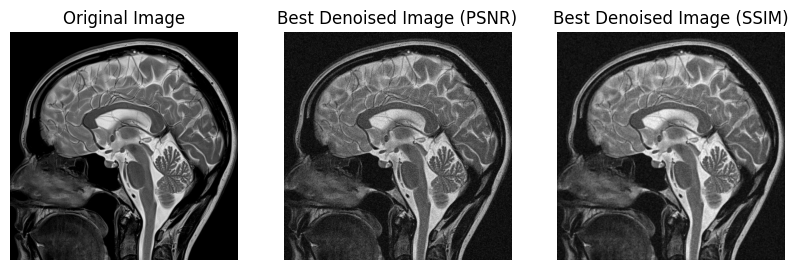

In [9]:
bestDenoisedPNSR2=anisotropicFilter(noisyImg, 20, 25, 0.05, 1)
bestDenoisedSSIM2=anisotropicFilter(noisyImg, 20, 45, 0.05, 2)
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(bestDenoisedPNSR2, cmap='gray')
plt.title('Best Denoised Image (PSNR)')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(bestDenoisedSSIM2, cmap='gray')
plt.title('Best Denoised Image (SSIM)')
plt.axis('off')

plt.show()

## saving the best images by comparing outputs of two options

In [10]:
cv.imwrite('bestDenoisedPNSR.png', bestDenoisedPNSR1)
cv.imwrite('bestDenoisedSSIM.png', bestDenoisedSSIM1)

True